## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
torch.cuda.empty_cache()

SEED = 1937

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 150x150 px, так как моему процессору не хватает памяти
RESCALE_SIZE = 150
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        #для аугментации, чтобы не возникало переобучения
        transform1 = transforms.Compose([
           transforms.ColorJitter(brightness=0.3, contrast=0.3),
           transforms.RandomRotation(45),
           transforms.RandomHorizontalFlip()
         ])
        if self.mode == 'train':
            image = transform1(image)
            image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        if self.mode == 'val' or self.mode == 'test':
            image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels)

Давайте посмотрим на наших героев внутри датасета.

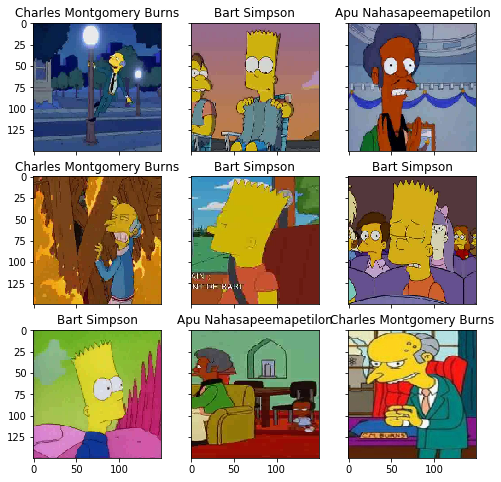

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети
В данном задании использую готовую модель нейросети Resnet18, так как она имеет довольно хорошие показатели.

In [11]:
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Видим, что на вход Fully-Connected слоя подаётся *512 признаков*. Это и будет размер входа для нашего нового fc.
Буду обучать не только последний **fully connected** слой, но и несколько предпоследних.
Так как, все слои нейросети обучаются заново, сделаю так, чтобы на них *не распространялся backpropagation* (заморожу их), и изменю FC-слой. (ведь старый уже с весами для ImageNet'а).

In [12]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model.layer1[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
for param in model.layer2[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
for param in model.layer3[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
for param in model.layer4[:-layers_to_unfreeze].parameters():
    param.requires_grad = False   
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, 42)
# Использовать GPU
model = model.cuda()

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    #задаём размер батча и перемешиваем train данные
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # В качестве cost function используем кросс-энтропию
        criterion = nn.CrossEntropyLoss().to(DEVICE)
        # Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
        # parameters() возвращает просто список тензоров парамтеров, поэтому пять таких списков можно сложить
        optimizer_ft = optim.AdamW(list(model.layer1.parameters())[-layers_to_unfreeze:]+
                                   list(model.layer2.parameters())[-layers_to_unfreeze:]+
                                   list(model.layer3.parameters())[-layers_to_unfreeze:]+
                                   list(model.layer4.parameters())[-layers_to_unfreeze:]+
                                   list(model.fc.parameters()), lr = 0.001)
        # Умножаю learning_rate на 0.1 каждые 3 эпохи
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer_ft)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            exp_lr_scheduler.step(val_loss)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [17]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [18]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=120)

epoch:   0%|                                            | 0/20 [00:00<?, ?it/s]

loss 0.9658293502811718


epoch:   5%|█▋                               | 1/20 [03:13<1:01:10, 193.20s/it]


Epoch 001 train_loss: 0.9658     val_loss 0.4339 train_acc 0.7503 val_acc 0.8866
loss 0.5617440282252048


epoch:  10%|███▌                               | 2/20 [06:17<57:08, 190.46s/it]


Epoch 002 train_loss: 0.5617     val_loss 0.3780 train_acc 0.8474 val_acc 0.9002
loss 0.40994718439132244


epoch:  15%|█████▎                             | 3/20 [09:18<53:10, 187.65s/it]


Epoch 003 train_loss: 0.4099     val_loss 0.3348 train_acc 0.8877 val_acc 0.9135
loss 0.33284074307790756


epoch:  20%|███████                            | 4/20 [12:17<49:20, 185.00s/it]


Epoch 004 train_loss: 0.3328     val_loss 0.2862 train_acc 0.9070 val_acc 0.9224
loss 0.28436161037394325


epoch:  25%|████████▊                          | 5/20 [15:20<46:05, 184.38s/it]


Epoch 005 train_loss: 0.2844     val_loss 0.3144 train_acc 0.9202 val_acc 0.9193
loss 0.24578918497949379


epoch:  30%|██████████▌                        | 6/20 [18:18<42:35, 182.53s/it]


Epoch 006 train_loss: 0.2458     val_loss 0.2760 train_acc 0.9304 val_acc 0.9286
loss 0.21878437518496874


epoch:  35%|████████████▎                      | 7/20 [21:18<39:23, 181.81s/it]


Epoch 007 train_loss: 0.2188     val_loss 0.3292 train_acc 0.9378 val_acc 0.9131
loss 0.2043485709765358


epoch:  40%|██████████████                     | 8/20 [24:17<36:12, 181.00s/it]


Epoch 008 train_loss: 0.2043     val_loss 0.2848 train_acc 0.9402 val_acc 0.9281
loss 0.18045284616951446


epoch:  45%|███████████████▊                   | 9/20 [27:17<33:07, 180.67s/it]


Epoch 009 train_loss: 0.1805     val_loss 0.2895 train_acc 0.9475 val_acc 0.9231
loss 0.17337597068899724


epoch:  50%|█████████████████                 | 10/20 [30:17<30:04, 180.48s/it]


Epoch 010 train_loss: 0.1734     val_loss 0.2470 train_acc 0.9504 val_acc 0.9365
loss 0.15831886813583787


epoch:  55%|██████████████████▋               | 11/20 [33:14<26:56, 179.58s/it]


Epoch 011 train_loss: 0.1583     val_loss 0.2786 train_acc 0.9522 val_acc 0.9338
loss 0.14586239659158357


epoch:  60%|████████████████████▍             | 12/20 [36:26<24:26, 183.28s/it]


Epoch 012 train_loss: 0.1459     val_loss 0.2712 train_acc 0.9584 val_acc 0.9341
loss 0.1318760398416291


epoch:  65%|██████████████████████            | 13/20 [39:37<21:39, 185.59s/it]


Epoch 013 train_loss: 0.1319     val_loss 0.2513 train_acc 0.9601 val_acc 0.9401
loss 0.11973222187346175


epoch:  70%|███████████████████████▊          | 14/20 [42:43<18:34, 185.74s/it]


Epoch 014 train_loss: 0.1197     val_loss 0.2675 train_acc 0.9628 val_acc 0.9405
loss 0.12282134579452551


epoch:  75%|█████████████████████████▌        | 15/20 [45:52<15:33, 186.63s/it]


Epoch 015 train_loss: 0.1228     val_loss 0.2441 train_acc 0.9641 val_acc 0.9429
loss 0.11061562183177928


epoch:  80%|███████████████████████████▏      | 16/20 [49:01<12:29, 187.32s/it]


Epoch 016 train_loss: 0.1106     val_loss 0.2588 train_acc 0.9666 val_acc 0.9436
loss 0.09969256507831421


epoch:  85%|████████████████████████████▉     | 17/20 [52:08<09:21, 187.18s/it]


Epoch 017 train_loss: 0.0997     val_loss 0.2457 train_acc 0.9708 val_acc 0.9410
loss 0.09717264459396681


epoch:  90%|██████████████████████████████▌   | 18/20 [55:15<06:14, 187.25s/it]


Epoch 018 train_loss: 0.0972     val_loss 0.2744 train_acc 0.9712 val_acc 0.9381
loss 0.0994060097915624


epoch:  95%|████████████████████████████████▎ | 19/20 [58:22<03:06, 186.99s/it]


Epoch 019 train_loss: 0.0994     val_loss 0.2796 train_acc 0.9695 val_acc 0.9412
loss 0.09637940303292039


epoch: 100%|████████████████████████████████| 20/20 [1:01:28<00:00, 184.41s/it]


Epoch 020 train_loss: 0.0964     val_loss 0.2768 train_acc 0.9707 val_acc 0.9389


In [19]:
loss, acc, val_loss, val_acc = zip(*history)

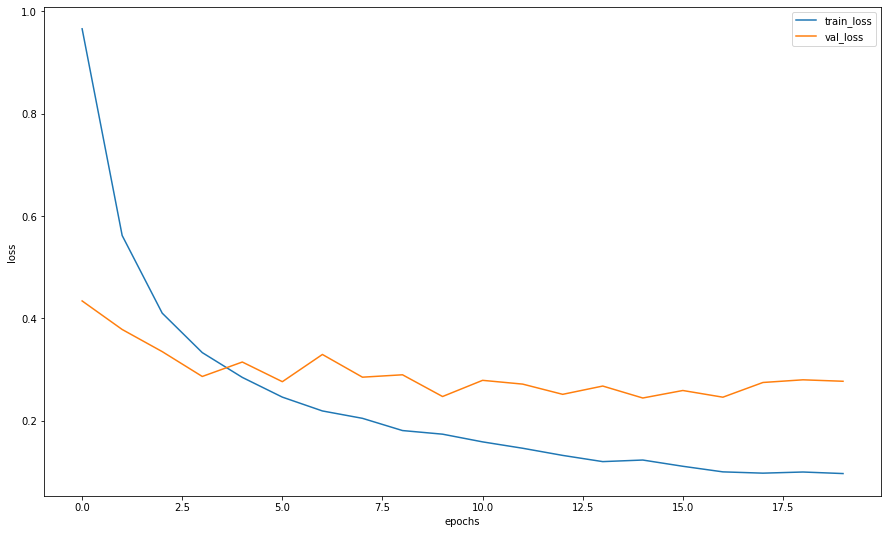

In [20]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Видим, что обучение происходило не со слишком большим переобучением, значит можем использовать модель для предсказания.

У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [21]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [22]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [23]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)

In [24]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику на валидационной выборке.

In [26]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

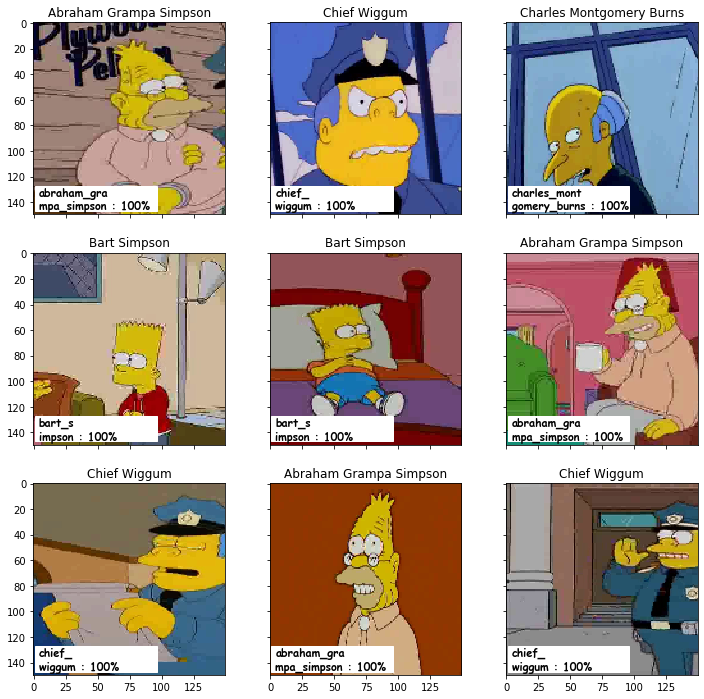

In [27]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((1, 127),95,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(4, 128, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=11, color='black',fontweight='bold')

Видим, что сеть уверенно предсказывает персонажей, значит можно составить submitt и отправить его на проверку.

In [28]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [29]:
import pandas as pd
import pandas as pd
submit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit[f'Expected'] = preds
submit.to_csv('submission.csv', index=False)
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


### Выводы

Изначально необходимо было подготовить данные. Так как их мало, то использовал аугментацию(transforms.ColorJitter, transforms.RandomRotation,transforms.RandomHorizontalFlip) для обучающих данных(train данных). 
Составленная нейросоть, взятая с соревнования не давала хороших результатов. Чтобы улучшить показатели было принято решение использовать обученную на ImageNet нейросеть Resnet18. Заново обучать её не было смысло, поэтому я заморозил слои, то есть выключил подсчёт их градиентов, и обучал только несколько последних. Метрика на валидационных данных показала 1.0, поэтому улучшать модель дальше не пришлось.